In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model, Layer

In [2]:
# === 1. Ładowanie danych IMDB ===
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CM86ID_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CM86ID_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CM86ID_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
# === 2. Przygotowanie danych (batch, shuffle, prefetch) ===
batch_size = 32

train_data = train_data.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [4]:
# === 3. Opakowanie KerasLayer, aby działał z TF 2.17 ===
class HubTextEmbedding(Layer):
    def __init__(self, hub_url, trainable=True):
        super().__init__()
        self.embedding_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.embedding_layer(inputs)

In [5]:
# === 4. Budowa modelu ===
hub_url = "https://tfhub.dev/google/nnlm-en-dim50/2"
input_text = Input(shape=(), dtype=tf.string, name="text_input")
embedding = HubTextEmbedding(hub_url)(input_text)
x = Dense(16, activation='relu')(embedding)
output = Dense(1)(x)

model = Model(inputs=input_text, outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_text_embedding              │ (None, 50)             │             0 │
│ (HubTextEmbedding)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# === 5. Trening ===
history = model.fit(train_data,
                    validation_data=validation_data,
                    epochs=5)

# === 6. Ewaluacja ===
loss, accuracy = model.evaluate(test_data)
print(f"\nLoss: {loss:.4f} | Accuracy: {accuracy:.4f}")

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5590 - loss: 0.6651 - val_accuracy: 0.6894 - val_loss: 0.5709
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6838 - loss: 0.5629 - val_accuracy: 0.7137 - val_loss: 0.5318
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7184 - loss: 0.5252 - val_accuracy: 0.7310 - val_loss: 0.5232
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7223 - loss: 0.5164 - val_accuracy: 0.7152 - val_loss: 0.5211
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7237 - loss: 0.5220 - val_accuracy: 0.7432 - val_loss: 0.5211
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7291 - loss: 0.5346

Loss: 0.5275 | Accuracy: 0.7344


In [9]:
# === 7. Predykcje na próbkach testowych i wykres ===

# Wybieramy 1 batch z danych testowych
example_batch = next(iter(test_data))  # pobierz pierwszą partię danych
text_batch, label_batch = example_batch
test_examples = text_batch[:5]         # weź 5 przykładów
true_labels = label_batch[:5].numpy()

# Predykcje modelu
raw_preds = model.predict(test_examples)
pred_probs = tf.sigmoid(raw_preds).numpy().flatten()

# Dekodowanie recenzji (z bytes do string)
decoded_reviews = [ex.numpy().decode("utf-8") for ex in test_examples]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


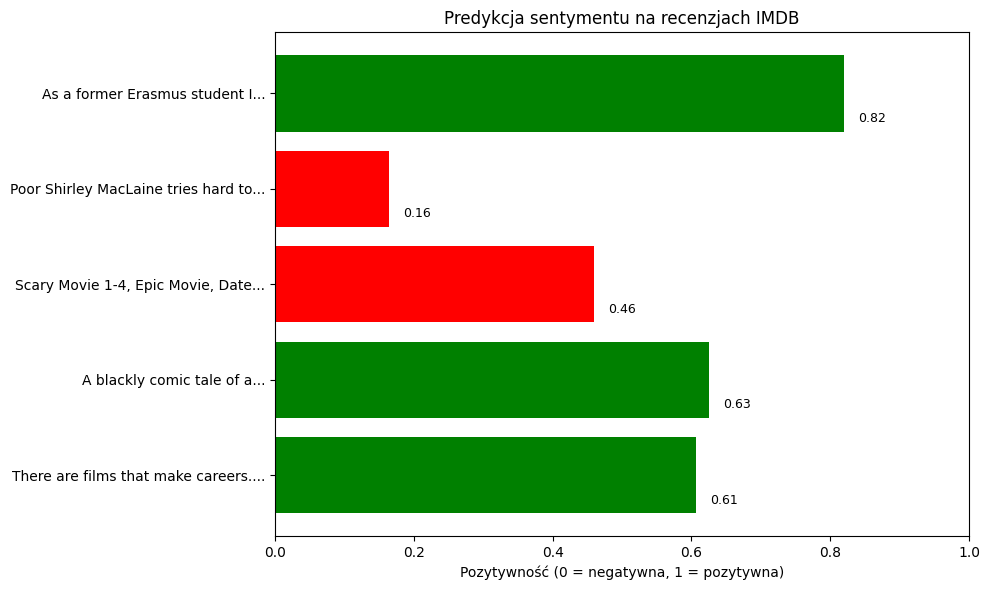

In [10]:
# === 8. Wizualizacja ===
plt.figure(figsize=(10, 6))
colors = ['green' if p > 0.5 else 'red' for p in pred_probs]
bars = plt.barh(range(len(decoded_reviews)), pred_probs, color=colors)
plt.yticks(range(len(decoded_reviews)), [" ".join(r.split()[:6]) + "..." for r in decoded_reviews])
plt.xlabel("Pozytywność (0 = negatywna, 1 = pozytywna)")
plt.title("Predykcja sentymentu na recenzjach IMDB")
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.02, bar.get_y() + 0.1, f"{pred_probs[i]:.2f}", fontsize=9)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()